In [1]:
import os 
os.chdir(os.environ['PYTHONPATH'])


In [2]:
import matplotlib.pyplot as plt
from nltk.lm.models import LanguageModel, Lidstone, KneserNeyInterpolated
import numpy as np
import pandas as pd

from code.model_selection import (
    get_min_per_order,
    get_train_set, 
    kfold_validation_entropy, 
    LMDef,
    plot_tuning_results,
    read_csv_to_df,
    write_kn_results_to_file,
    write_lidstone_results_to_file,
)
from code.ngrams import MyNGram


In [3]:
# set up the models+hyperparameters we want to test 
test_orders = [1, 2, 3, 4]

lidstone_test_alphas = sorted(set(
    np.concatenate((np.linspace(0, .005, 6), np.linspace(0, .001, 11)))
))[1:] 
lidstone_test_alphas_simple = np.linspace(0, .005, 6)[1:]   # 0-0.005 excluding 0

kn_test_discounts = sorted(set(
    np.concatenate((
        np.linspace(0, 1, 6),
        np.linspace(0.41, 0.51, 11),
        np.linspace(0.19, 0.29, 11),
    ))
))[1:]
kn_test_discounts_simple = np.linspace(0, 1, 6)[1:]  # 0-1 excluding 0

assert set(lidstone_test_alphas_simple).issubset(lidstone_test_alphas)
assert set(kn_test_discounts_simple).issubset(kn_test_discounts)


In [4]:
# define all the models we want to test

lidstone_models = [
    LMDef(
        Lidstone,
        [alpha, order],
        evaluate_on_training_set=(alpha in lidstone_test_alphas_simple),
    )
    for alpha in lidstone_test_alphas for order in test_orders
]

kn_models = [
    LMDef(
        KneserNeyInterpolated,
        args=[order],
        kwargs={'discount': discount},
        evaluate_on_training_set=(discount in kn_test_discounts_simple),
    )
    for discount in kn_test_discounts for order in test_orders
]


In [5]:
# get training data from file 
training_corpus = get_train_set()


In [6]:
# k-fold validation, calculate average entropy for each model 
lidstone_results = kfold_validation_entropy(
    lidstone_models, training_corpus, n_splits=4, 
    progressbars='outer',
)

# write results to file 
lidstone_filename = write_lidstone_results_to_file(lidstone_results)
print(lidstone_filename)


test models entropy: 100%|██████████| 56/56 [08:54<00:00,  9.54s/it]

data/model_selection_lidstone_1616613464.csv


In [7]:
# or, use existing file 
# lidstone_filename = 'data/model_selection_lidstone_1616609697.csv'

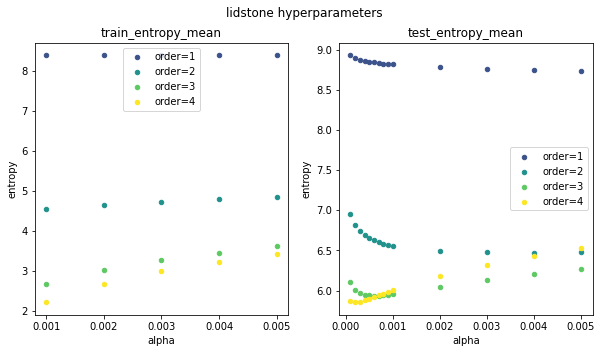

In [8]:
# read results into pandas dataframe and plot them
lidstone_df = read_csv_to_df(lidstone_filename)
plot_tuning_results(lidstone_df, 'lidstone', 'alpha')

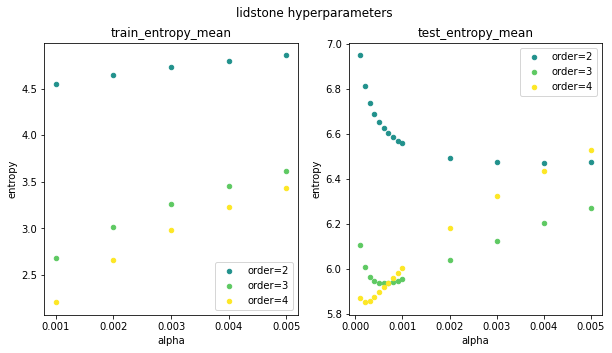

In [9]:
# plot again without unigram results
plot_tuning_results(lidstone_df[lidstone_df.order!=1], 'lidstone', 'alpha')


In [10]:
mins_per_order_lidstone = get_min_per_order(lidstone_df, column='test_entropy_mean')
lowest_test_entropies_lidstone = mins_per_order_lidstone[
    ['model', 'order', 'alpha', 'test_entropy_mean']
]

display(lowest_test_entropies_lidstone)

,model,order,alpha,test_entropy_mean
52,Lidstone,1,0.0050,8.738306
49,Lidstone,2,0.0040,6.472088
22,Lidstone,3,0.0006,5.936380
7,Lidstone,4,0.0002,5.851572


In [11]:
# now do the same except for kneser-ney models 

kn_results = kfold_validation_entropy(
    kn_models, training_corpus, n_splits=4, progressbars='outer',
)
kn_filename = write_kn_results_to_file(kn_results)
print(kn_filename)


test models entropy: 100%|██████████| 104/104 [17:23<00:00, 10.03s/it]

data/model_selection_kn_1616614508.csv


In [12]:
# # or, use existing file 
# kn_filename = 'data/model_selection_kn_1616611530.csv'

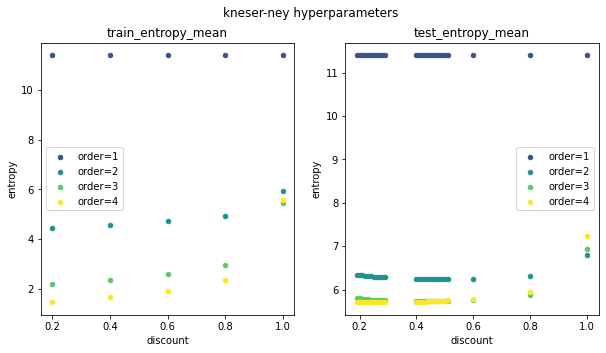

In [13]:
# plot results 
kn_df = read_csv_to_df(kn_filename)
plot_tuning_results(kn_df, 'kneser-ney', 'discount')

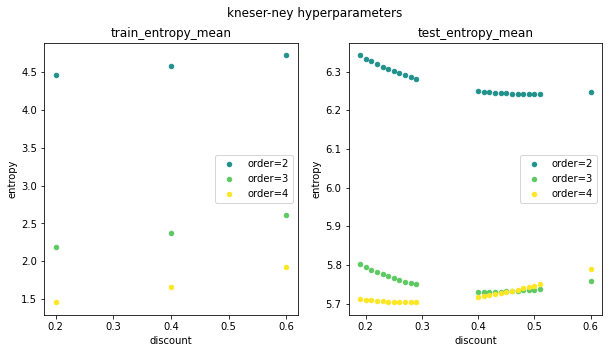

In [14]:
# zoom 
plot_tuning_results(
    kn_df[(kn_df.order!=1) & (kn_df.discount < 0.7)], 
    'kneser-ney', 'discount',
)


In [15]:
mins_per_order_kn = get_min_per_order(kn_df, column='test_entropy_mean')
lowest_test_entropies_kn = mins_per_order_kn[
    ['model', 'order', 'discount', 'test_entropy_mean']
]

display(lowest_test_entropies_kn)

,model,order,discount,test_entropy_mean
0,KneserNeyInterpolated,1,0.19,11.399850
85,KneserNeyInterpolated,2,0.50,6.241376
54,KneserNeyInterpolated,3,0.42,5.730633
39,KneserNeyInterpolated,4,0.28,5.702818


In [16]:
best_models = [
    LMDef(
        class_=Lidstone,
        args=[row.alpha, row.order],
    )
    for row in lowest_test_entropies_lidstone.itertuples()
] + [
    LMDef(
        class_=KneserNeyInterpolated,
        args=[row.order],
        kwargs={'discount': row.discount},
    )
    for row in lowest_test_entropies_kn.itertuples()
]

In [17]:
print(len(best_models))

8
